In [73]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History

# 1) Data Wrangling

In [2]:
ad_df = pd.read_csv('alzheimer.csv')

In [3]:
ad_df

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,Demented,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,Demented,M,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...
368,Demented,M,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,Demented,M,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,Nondemented,F,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,Nondemented,F,63,13,2.0,30.0,0.0,1327,0.796,1.323


In [4]:
ad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Group   373 non-null    object 
 1   M/F     373 non-null    object 
 2   Age     373 non-null    int64  
 3   EDUC    373 non-null    int64  
 4   SES     354 non-null    float64
 5   MMSE    371 non-null    float64
 6   CDR     373 non-null    float64
 7   eTIV    373 non-null    int64  
 8   nWBV    373 non-null    float64
 9   ASF     373 non-null    float64
dtypes: float64(5), int64(3), object(2)
memory usage: 29.3+ KB


In [5]:
ad_df.isna().sum()

Group     0
M/F       0
Age       0
EDUC      0
SES      19
MMSE      2
CDR       0
eTIV      0
nWBV      0
ASF       0
dtype: int64

In [6]:
# Fill NaN values for Socioeconomic status
# Drop the 2 rows that have 0 as the value in MMSE

ad_df.SES.fillna(0, inplace= True)
ad_df.dropna(how= 'any',inplace= True)

I dropped the 2 rows with NaN in column 'MMSE' because I have no way of knowing what values to impute. Looking at the data, there was no correlation (atleast intuitively) that I could find in order to impute a number for those missing values. Regardless, the affect of it towards the analysis will be negligible.
Furthermore, I reassigned the missing values from the Socioeconomic Status colume to 0, which -for the sake of our analysis- will mean 'None Given'.

In [7]:
ad_df

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,M,75,12,0.0,23.0,0.5,1678,0.736,1.046
3,Demented,M,76,12,0.0,28.0,0.5,1738,0.713,1.010
4,Demented,M,80,12,0.0,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...
368,Demented,M,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,Demented,M,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,Nondemented,F,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,Nondemented,F,63,13,2.0,30.0,0.0,1327,0.796,1.323


In [8]:
ad_df.Group.unique()

array(['Nondemented', 'Demented', 'Converted'], dtype=object)

In [9]:
ad_df = ad_df[ad_df['Group'].isin(['Demented', 'Nondemented'])]

In [10]:
ad_df = ad_df.rename(columns= {'M/F': 'Gender'})

In [11]:
ad_df = ad_df.reset_index()

In [12]:
ad_df.drop('index', axis= 1, inplace= True)

In [13]:
ad_df['SES'] = ad_df.SES.astype('int')

In [14]:
ad_df

,Group,Gender,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,M,87,14,2,27.0,0.0,1987,0.696,0.883
1,Nondemented,M,88,14,2,30.0,0.0,2004,0.681,0.876
2,Demented,M,75,12,0,23.0,0.5,1678,0.736,1.046
3,Demented,M,76,12,0,28.0,0.5,1738,0.713,1.010
4,Demented,M,80,12,0,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...
329,Demented,M,82,16,1,28.0,0.5,1693,0.694,1.037
330,Demented,M,86,16,1,26.0,0.5,1688,0.675,1.040
331,Nondemented,F,61,13,2,30.0,0.0,1319,0.801,1.331
332,Nondemented,F,63,13,2,30.0,0.0,1327,0.796,1.323


In [15]:
ad_df.to_csv(path_or_buf= 'ad_df.csv')

# 2) Exploratory Data Analysis

In [16]:
ad_df = pd.read_csv('ad_df.csv')

In [17]:
ad_df.drop('Unnamed: 0', axis= 1, inplace= True)

In [16]:
group_enc = {'Nondemented': 0, 'Demented': 1}
sex_enc = {'M': 0, 'F': 1}

In [19]:
ad_df.Group.replace(group_enc, inplace= True)
ad_df.Gender.replace(sex_enc, inplace= True)

In [20]:
ad_df

,Group,Gender,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,0,87,14,2,27.0,0.0,1987,0.696,0.883
1,0,0,88,14,2,30.0,0.0,2004,0.681,0.876
2,1,0,75,12,0,23.0,0.5,1678,0.736,1.046
3,1,0,76,12,0,28.0,0.5,1738,0.713,1.010
4,1,0,80,12,0,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...
329,1,0,82,16,1,28.0,0.5,1693,0.694,1.037
330,1,0,86,16,1,26.0,0.5,1688,0.675,1.040
331,0,1,61,13,2,30.0,0.0,1319,0.801,1.331
332,0,1,63,13,2,30.0,0.0,1327,0.796,1.323


In [21]:
ad_df.describe()

,Group,Gender,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000
mean,0.431138,0.559880,76.715569,14.517964,2.416168,27.194611,0.290419,1493.266467,0.730168,1.191713
std,0.495978,0.497146,7.637032,2.902516,1.229215,3.819639,0.382929,178.677199,0.037419,0.139206
min,0.000000,0.000000,60.000000,6.000000,0.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,0.000000,0.000000,71.000000,12.000000,1.250000,26.000000,0.000000,1358.250000,0.700250,1.096500
50%,0.000000,1.000000,76.000000,14.000000,2.000000,29.000000,0.000000,1475.500000,0.731000,1.189500
75%,1.000000,1.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1601.250000,0.756000,1.292500
max,1.000000,1.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [22]:
ad_corr = ad_df.corr()

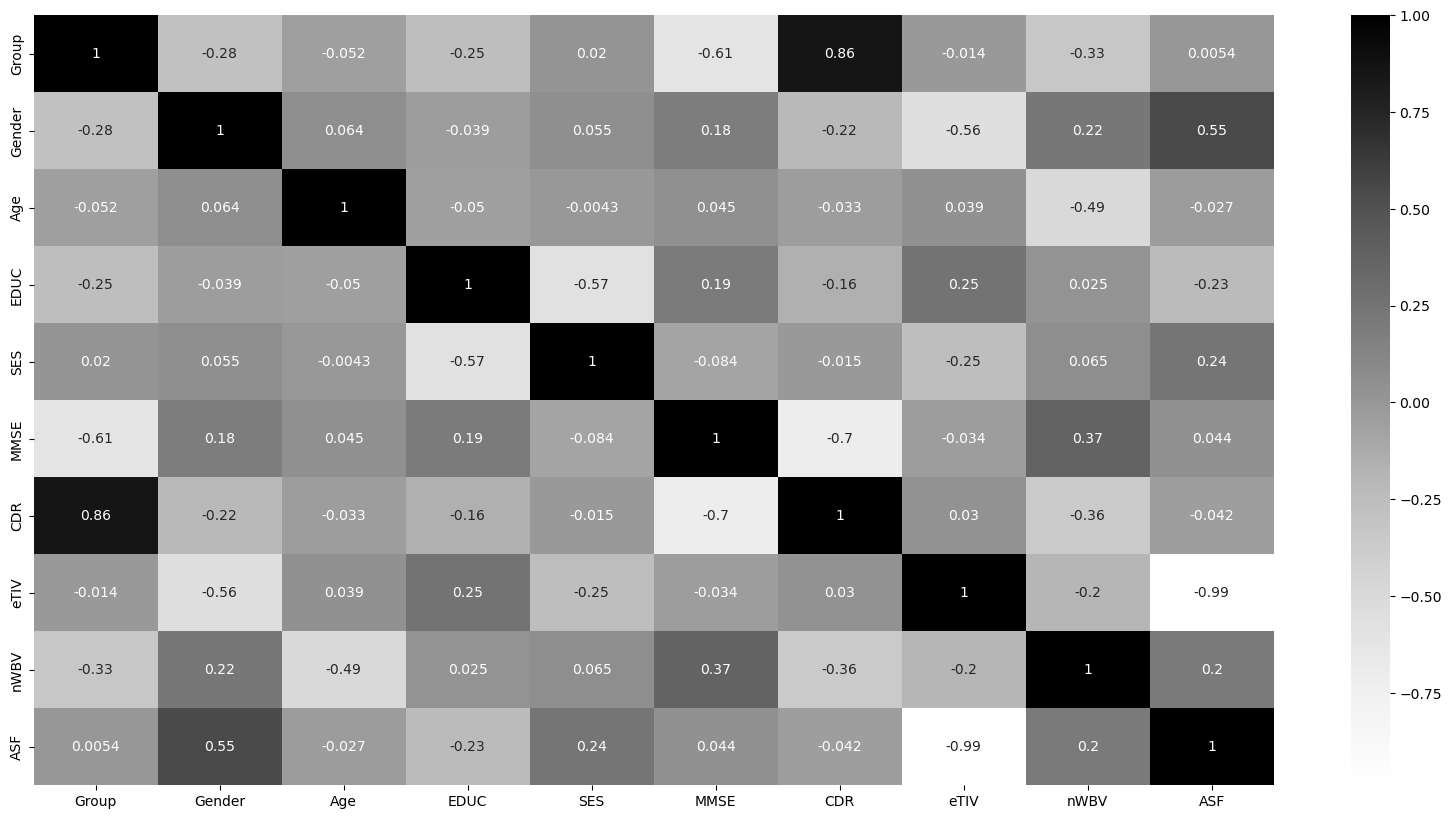

In [307]:
_ = plt.figure(figsize= (20, 10))
_ = sns.heatmap(ad_corr, annot= True, cmap= 'Greys')
plt.show()

It should go without saying that EDUC & SES are somewhat intuitively correlated.

eTIV and ASF are very negatively correlated since ASF uses eTIV for its volume-scaling process that matches individuals to an atlas target.

Let's graph each of these feature and explore the correlations further.

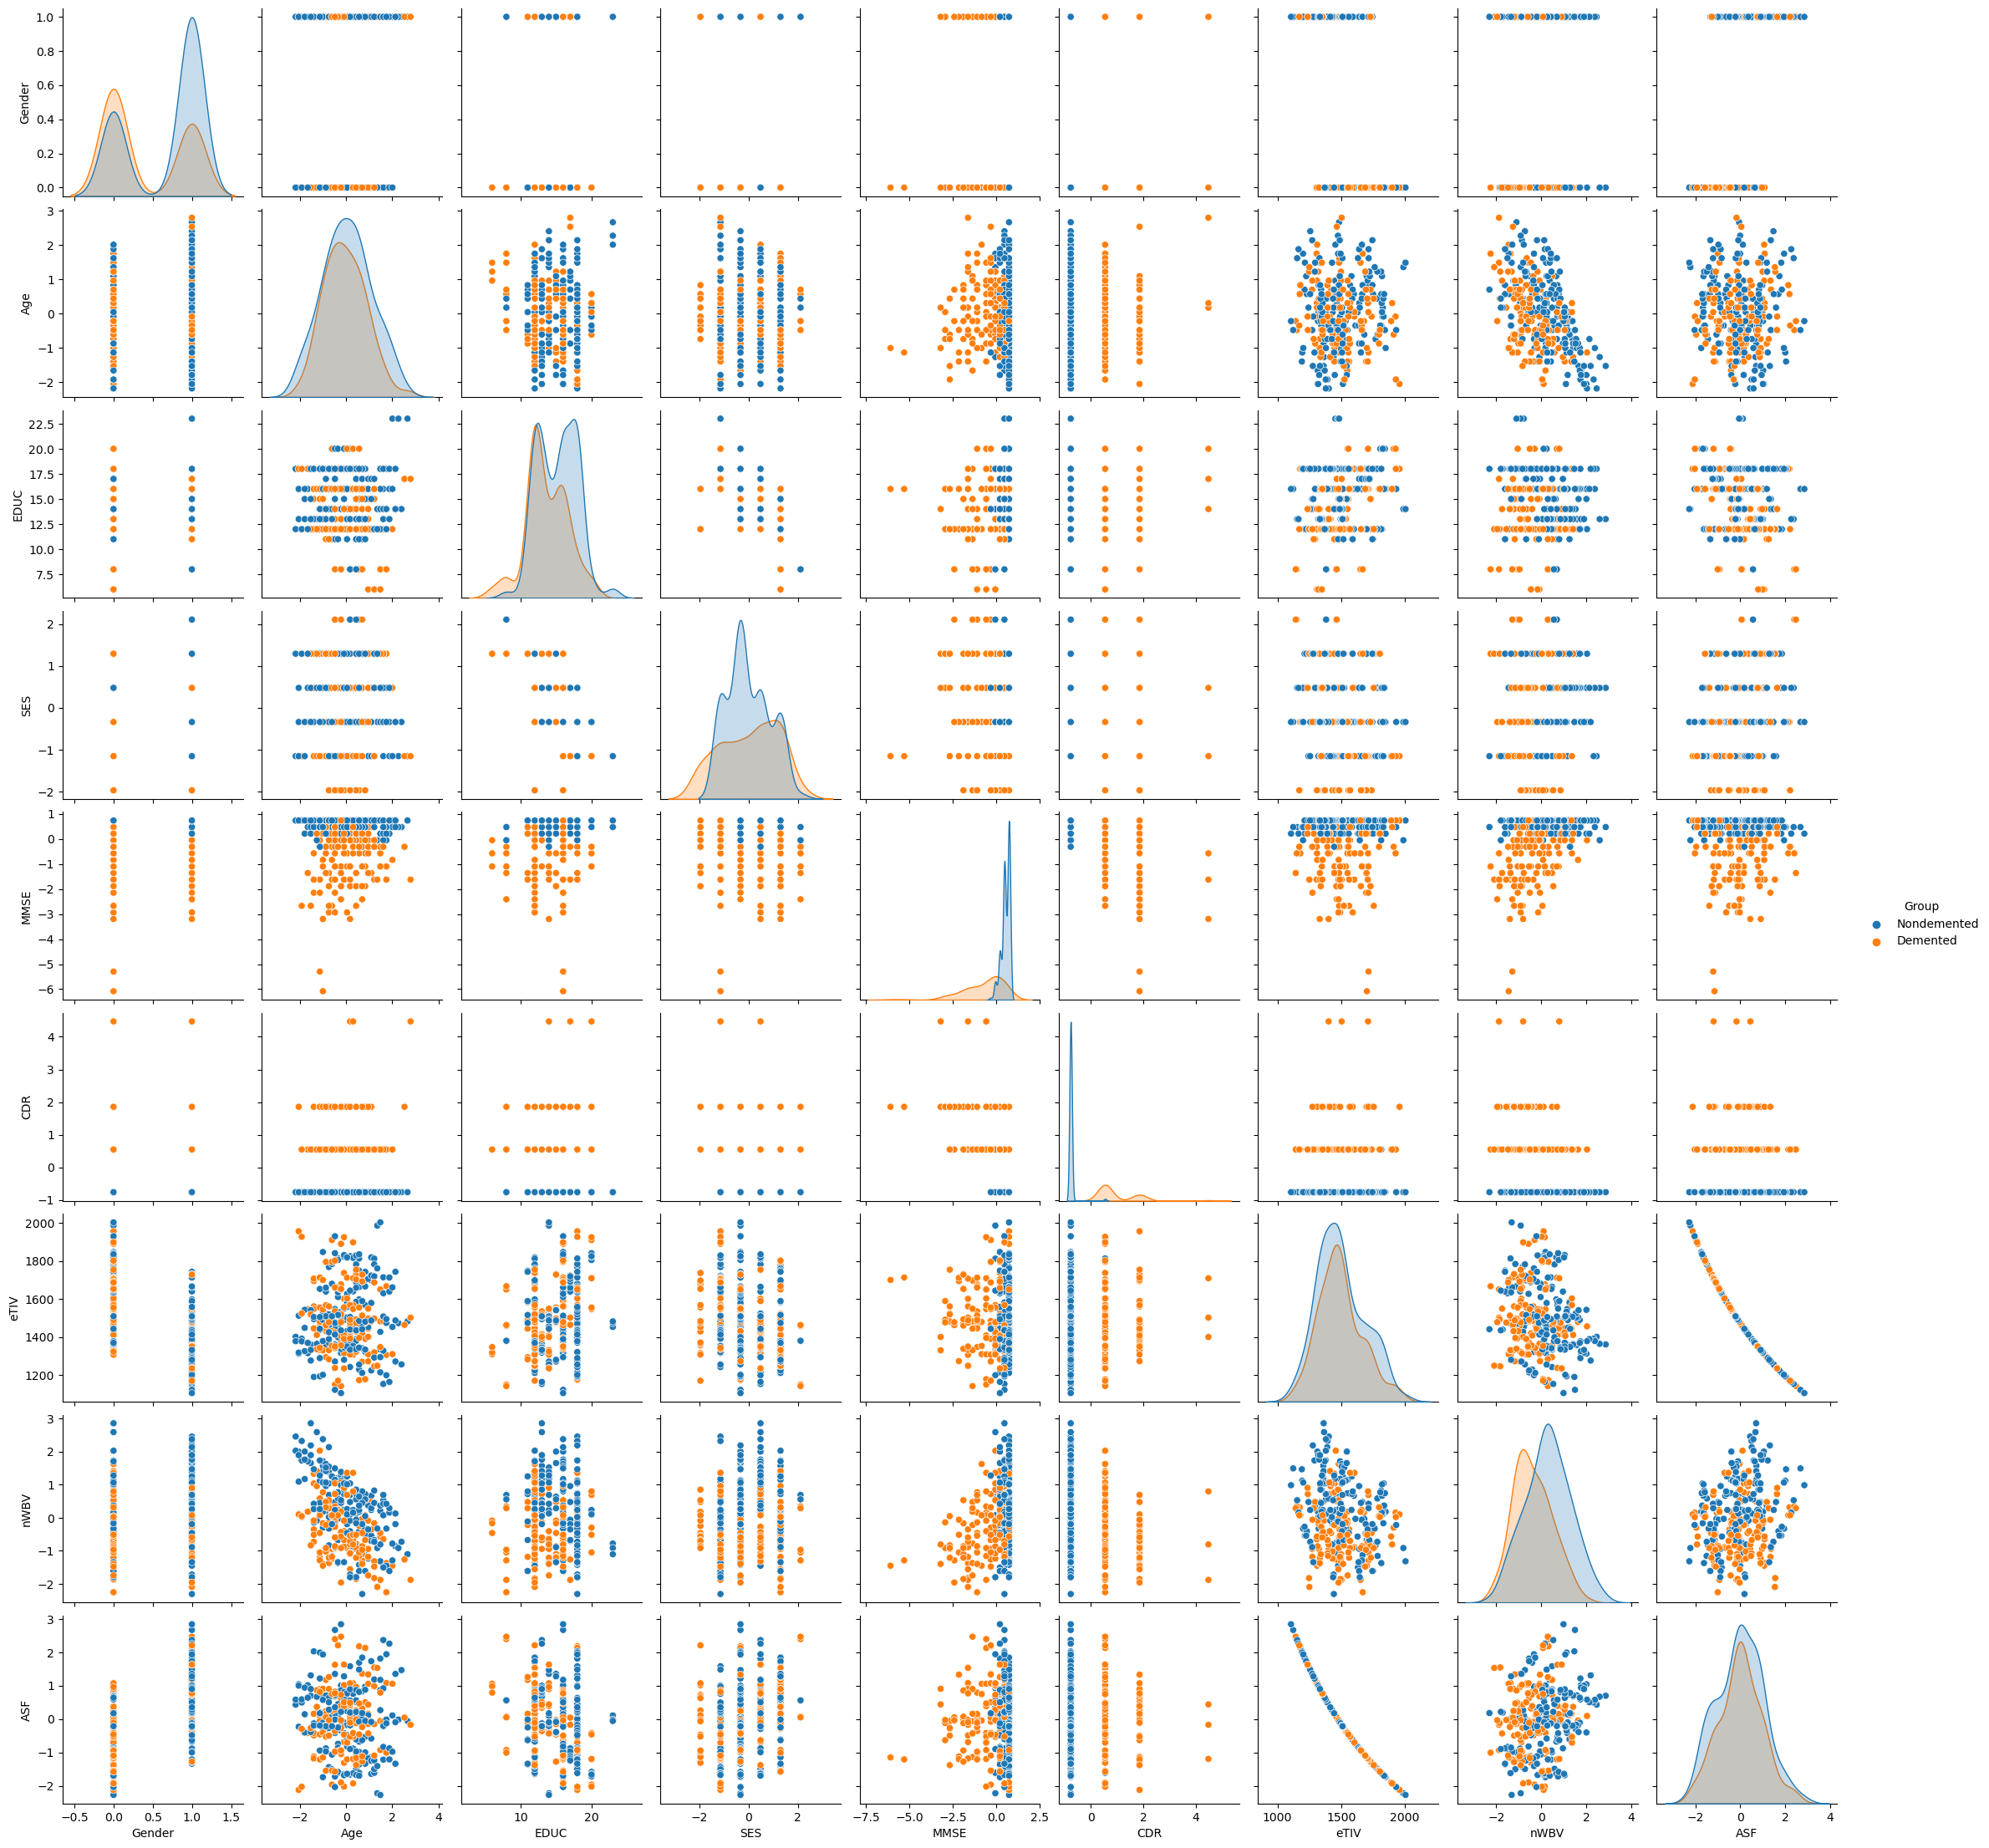

In [371]:
# For the purpose of formality, I changed the values of the 'Group' column back to their original form to better
# be depicted in the graphs below

un_enc = {0: 'Nondemented', 1: 'Demented'}
ad_df.Group.replace(un_enc, inplace= True)
_ = sns.pairplot(ad_df, hue= 'Group')
_ = plt.show()

Please take a look at the tableau story for graphs with better visualizations, and correlations of the pertinent features

In [25]:
# let's save what we have so far

ad_df.to_csv(path_or_buf= 'ad_df.csv')

# 3) Preprocessing

In [3]:
ad_df = pd.read_csv('ad_df.csv')

In [4]:
ad_df.drop('Unnamed: 0', axis= 1, inplace= True)

In [5]:
scaler = StandardScaler()

In [6]:
# These are the features that I'll be working with in my model, hence I need to Standarize it to improve
# model performcance and outcome

ad_df[['Age','SES', 'MMSE', 'CDR', 'nWBV', 'ASF']] = scaler.fit_transform(ad_df[['Age','SES', 'MMSE', 'CDR', 'nWBV','ASF']])

In [7]:
ad_df

,Group,Gender,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,0,1.348673,14,-0.339072,-0.051026,-0.759553,1987,-0.914488,-2.220989
1,Nondemented,0,1.479811,14,-0.339072,0.735567,-0.759553,2004,-1.315958,-2.271350
2,Demented,0,-0.224975,12,-1.968568,-1.099817,0.548131,1678,0.156101,-1.048309
3,Demented,0,-0.093838,12,-1.968568,0.211171,0.548131,1738,-0.459488,-1.307306
4,Demented,0,0.430712,12,-1.968568,-1.362015,0.548131,1698,-0.780664,-1.134641
...,...,...,...,...,...,...,...,...,...,...
329,Demented,0,0.692986,16,-1.153820,0.211171,0.548131,1693,-0.968017,-1.113058
330,Demented,0,1.217536,16,-1.153820,-0.313224,0.548131,1688,-1.476547,-1.091475
331,Nondemented,1,-2.060898,13,-0.339072,0.735567,-0.759553,1319,1.895807,1.002084
332,Nondemented,1,-1.798624,13,-0.339072,0.735567,-0.759553,1327,1.761984,0.944529


In [8]:
# Dimensionality reduction

pca = PCA(n_components= 4)
pca_feat = pca.fit_transform(ad_df[['Age','SES', 'MMSE', 'CDR', 'nWBV','ASF']])

In [9]:
pca_df = pd.DataFrame(pca_feat, columns= ['component_1', 'component_2', 'component_3', 'component_4'])

In [10]:
model_df = pd.concat([pca_df, ad_df[['Group', 'Gender']]], axis= 1)

In [11]:
model_df.head()

,component_1,component_2,component_3,component_4,Group,Gender
0,0.743196,2.349064,0.354941,-1.307079,Nondemented,0
1,0.544781,2.869095,0.163407,-1.324747,Nondemented,0
2,1.047007,0.452324,2.046264,0.657771,Demented,0
3,0.698088,1.321953,1.878667,0.496308,Demented,0
4,1.845867,1.095283,1.554736,0.652642,Demented,0


In [12]:
# Check out how much of the variance is explained by each component

pca.explained_variance_ratio_

array([0.33987746, 0.22980434, 0.19703033, 0.12556672])

In total, approximately 92.3% of the variance is explained. We will use this the 4 dimensional data for our modeling.

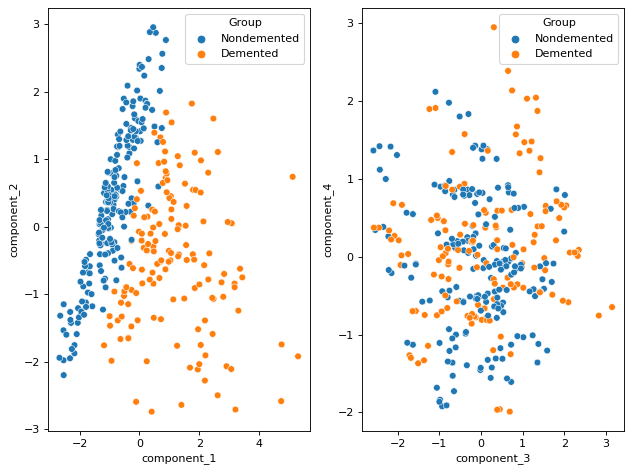

In [13]:
# Let's plot the components to see what we have, so we can get a sense of how the data looks with respect to the classification

_ = plt.figure(num=None, figsize=(8, 6), dpi=80)
_ = plt.subplot(1,2,1)
_ = sns.scatterplot(x= 'component_1', y= 'component_2', data= model_df, hue= 'Group')

_ = plt.subplot(1,2,2)
_ = sns.scatterplot(x= 'component_3', y= 'component_4', data= model_df, hue= 'Group')
_ = plt.tight_layout()
_ = plt.show()

As we can see, the higher the order the more "sporadic" the data points are. It is no surprise that the "Nondemented" data points are more linearly correlated as the data behind it has more of a similar -predictive- pattern.

# 4) Deep Learning

In [17]:
# Let's 'binarize' the Group column once more to prep for our model

ad_df.Group.replace(group_enc, inplace= True)

In [22]:
y = ad_df.Group.values

X_train, X_test, y_train, y_test = train_test_split(pca_feat, y, test_size= 0.30, random_state= 123)

In [110]:
model = Sequential()

In [111]:
# Our model will include 2 hidden layers with 10 and 4 outputs, respectively.
# The weights will be normalized at intiation of the layer to its independent of previous layers
# We will also include early stopping so the model can stop processing at its 'peak' condition

early_stop = EarlyStopping(monitor= 'val_loss', mode= 'min', patience= 2, verbose= 1)
model.add(Dense(10, input_shape= (4,), activation= 'relu', kernel_initializer= 'normal'))
model.add(Dense(4, input_shape= (10,), activation= 'relu', kernel_initializer= 'normal'))
model.add(Dense(1, activation= 'tanh'))
    
model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
history = model.fit(X_train, y_train, epochs= 300, verbose= 0, validation_data= (X_test, y_test), callbacks= [early_stop])

Epoch 00087: early stopping


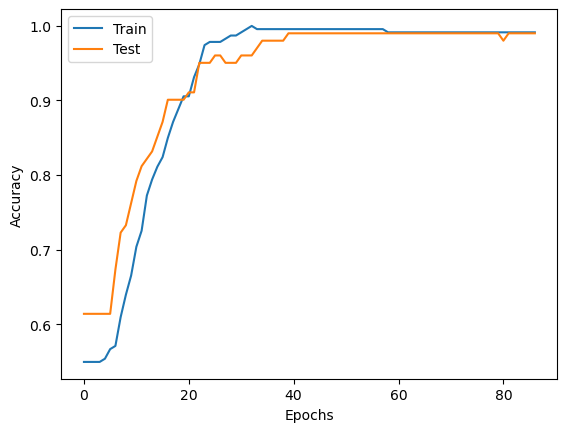

In [112]:
_ = plt.figure()
_ = plt.plot(history.history['accuracy'])
_ = plt.plot(history.history['val_accuracy'])
_ = plt.legend(['Train', 'Test'])
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Accuracy')
_ = plt.show()

In [116]:
# Model accuracy

model.evaluate(X_test, y_test, verbose= 0)[1]

0.9900990128517151

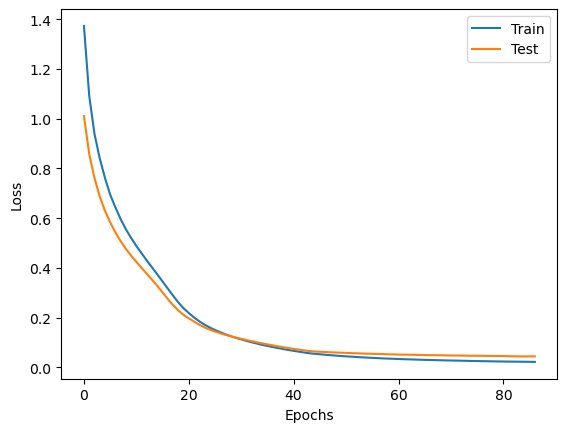

In [114]:
_ = plt.plot(history.history['loss'])
_ = plt.plot(history.history['val_loss'])
_ = plt.legend(['Train', 'Test'])
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Loss')
_ = plt.show()

The test data shows a convergence with the training data on learning loss at approximately 30 epochs. 
We can also see that our model isn't overfitting as the test data's loss curve is not increasing by the epochs.
Additionally, at 87 epochs epochs is where our model is at its optimal with 99% accuracy.

In [202]:
# Let's dig deeper and create a function for our model and test out different combinations of activation functions

activations = ['relu', 'sigmoid', 'softmax']

def model_select(activation_func):
    model.add(Dense(10, input_shape= (4,), activation= activation_func))
    model.add(Dense(2, input_shape= (10,), activation= activation_func))
    model.add(Dense(1, activation= 'tanh'))
    return model

In [203]:
activation_results = {}

for func in activations:
    model_select(func)    
    history = model.fit(X_train, y_train, epochs= 300, verbose= 0, validation_data= (X_test, y_test))
    activation_results[func] = history

In [206]:
val_acc_per_func = {k:v.history['val_accuracy'] for k,v in activation_results.items()}

In [207]:
val_acc_curves = pd.DataFrame(val_acc_per_func)

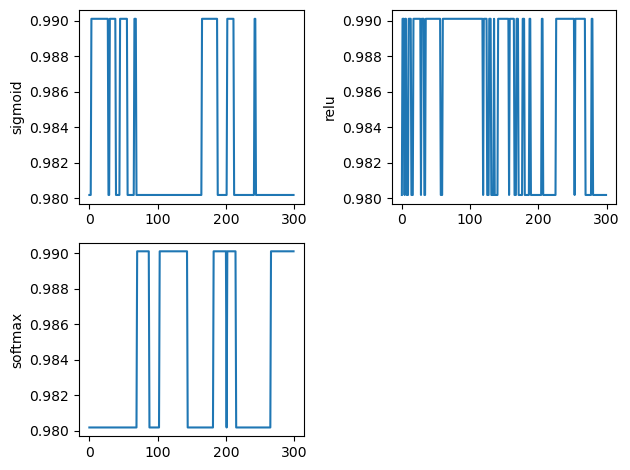

In [236]:
_ = plt.subplot(2,2,1)
_ = sns.lineplot(x= val_acc_curves.index, y = val_acc_curves.sigmoid, data= val_acc_curves)
_ = plt.subplot(2,2,2)
_ = sns.lineplot(x= val_acc_curves.index, y = val_acc_curves.relu, data= val_acc_curves)
_ = plt.subplot(2,2,3)
_ = sns.lineplot(x= val_acc_curves.index, y = val_acc_curves.softmax, data= val_acc_curves)
_ = plt.tight_layout()
_ = plt.show()

As shown above, it seems as if the relu activation function consistently gets a higher accuracy score than the others.
Hence, that is what will be used with the model that's already been created